# _Embeddings with Flair_

In [41]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm_notebook as tqdm
%config InlineBackend.figure_format = 'retina'

In [2]:
def home_path():
    return Path.cwd().parent

In [3]:
homepath = home_path()

In [4]:
%%time
df = pd.read_json(
    homepath/'storage/tweet_congress/mega-senate.json',
    orient='split'
)

CPU times: user 14.9 s, sys: 1.88 s, total: 16.7 s
Wall time: 16.7 s


In [13]:
sample = df.sample(n=10000, random_state=1)

In [14]:
sample.shape

(10000, 35)

## _Embeddings_

In [15]:
import torch
from flair.data import Sentence
from flair.embeddings import FlairEmbeddings, DocumentPoolEmbeddings, BertEmbeddings

# init embedding classes
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')
bert_embedding = BertEmbeddings('bert-base-uncased')

# combine word embedding models
document_embeddings = DocumentPoolEmbeddings([
    bert_embedding,
    flair_embedding_backward,
    flair_embedding_forward
])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  


In [23]:
# set up empty tensor
X = torch.empty(size=(len(sample.index), 7168)).cuda()

# fill in tensor with embeddings
i = 0
for text in tqdm(sample['tweet']):
    sentence = Sentence(text)
    document_embeddings.embed(sentence)
    embedding = sentence.get_embedding()
    X[i] = embedding
    i += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [24]:
X = X.cpu().detach().numpy()

In [25]:
torch.cuda.empty_cache()

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
X_scale = MinMaxScaler(feature_range=(-1,1)).fit_transform(X)

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import Isomap, LocallyLinearEmbedding

def pca_plot(X, max_dims=100):
    N = min(X.shape[1],max_dims)
    pca = PCA(n_components=N)
    pca.fit(X)
    _,ax = plt.subplots(figsize=(8,4))
    ax.plot(range(1,N+1),pca.explained_variance_ratio_.cumsum(), c='black', linewidth=2.)
    ax.set_xlim(0,N+1)
    ax.set_yticks(0.1*np.arange(11))
    ax.locator_params(axis='x', nbins=40)
    ax.set_xlabel('principal components')
    ax.set_ylabel('% of variance explained')
    plt.show()

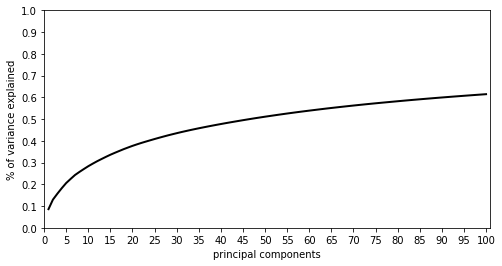

In [37]:
pca_plot(X_scale)

In [38]:
dr = PCA(n_components=2)
dr.fit(X_scale)
X_dr = dr.transform(X_scale)

In [39]:
def plot_reduced_2D(X_dr, dr_type):
    _,ax = plt.subplots(figsize=(8,8))
    ax.scatter(X_dr[:,0],X_dr[:,1],s=0.5,alpha=0.5)
    ax.set_title(dr_type+' with 2 components')
    plt.show()

X_dr shape:  (10000, 2)
X shape:  (10000, 7168)


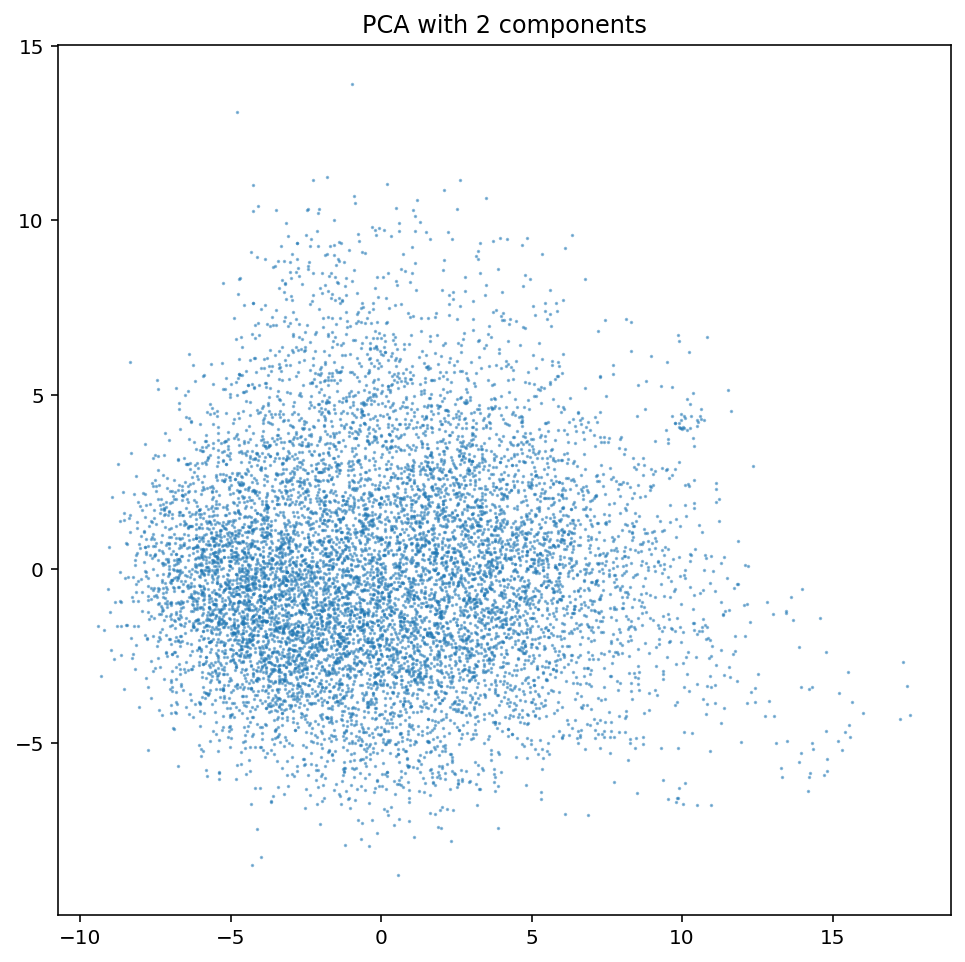

In [42]:
print('X_dr shape: ',X_dr.shape)
print('X shape: ',X.shape)
plot_reduced_2D(X_dr, 'PCA')

In [55]:
from umap import UMAP
import warnings; warnings.filterwarnings('ignore')

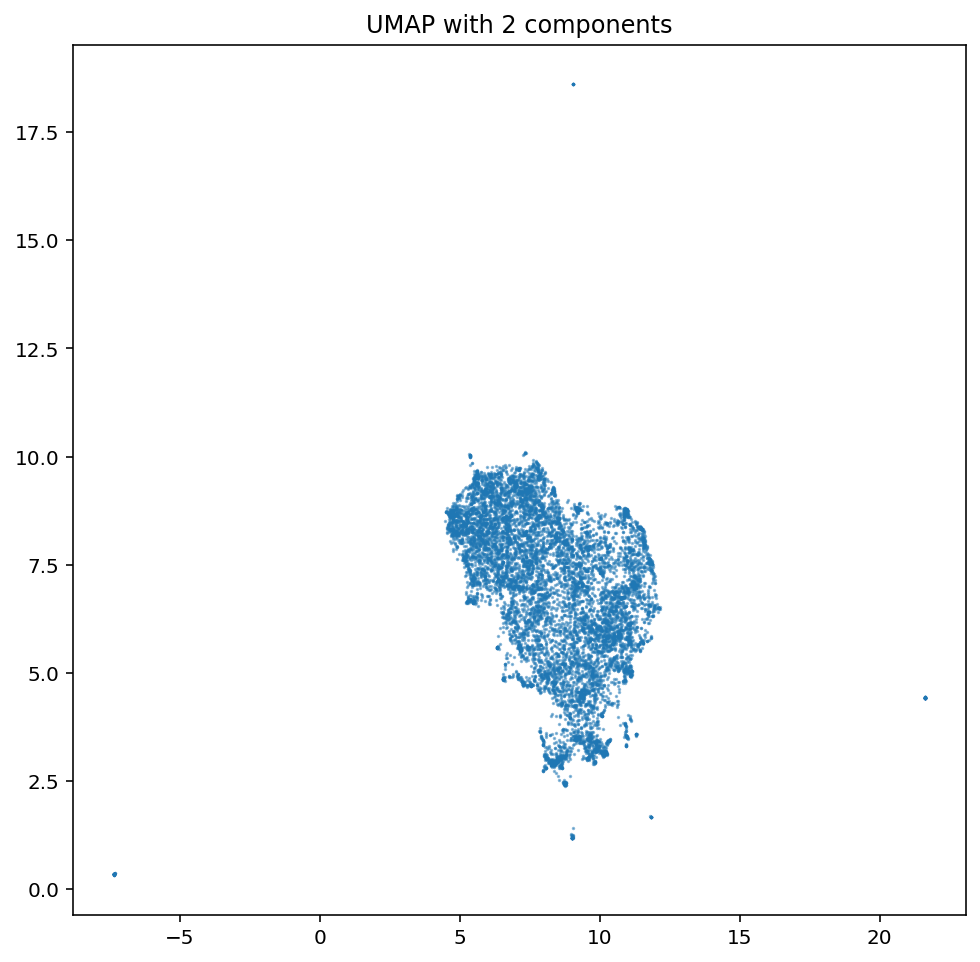

CPU times: user 2min 12s, sys: 2.57 s, total: 2min 14s
Wall time: 36.2 s


In [58]:
%%time
dr = UMAP(n_components=2, n_neighbors=10, min_dist=0.001)
dr.fit(X_scale)
X_dr = dr.transform(X_scale)
plot_reduced_2D(X_dr, 'UMAP')